## **EDA Notebook**

**IMPORTANT:** run `setup_data.py`

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os


import cv2
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
img_metadata_df = pd.read_csv('../image_metadata/image_data.csv')
img_metadata_df.isnull().sum()

path_to_image          0
Benign or Malignant    3
Cancer Type            4
Magnification          4
dtype: int64

In [3]:
img_metadata_df.dropna(inplace=True)
img_metadata_df.head(3)

path_to_image Benign or Malignant  \
0  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
1  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   
2  BreaKHis_v1/histology_slides/breast/benign/SOB...              Benign   

  Cancer Type Magnification  
0    Adenosis          100X  
1    Adenosis          100X  
2    Adenosis          100X

In [4]:
img_metadata_df.isnull().sum()

path_to_image          0
Benign or Malignant    0
Cancer Type            0
Magnification          0
dtype: int64

In [5]:
def update_image_paths(metadata):
    
    def get_image_location(row):
        
        possible_locations = ['train', 'test', 'val']
        for location in possible_locations:
            full_path = os.path.join('..', 'data', row['Magnification'], location, row['image_name'])
            if os.path.exists(full_path):
                return location
            
        print(f"WARNING: {row['image_name']} not found in any folder.")
        return "NOT FOUND"
    
    # These are temporary columns to help us find the new paths of the images
    metadata['image_name'] = metadata['path_to_image'].apply(lambda x: os.path.basename(x))
    metadata['image_location'] = metadata.apply(get_image_location, axis=1)
    
    # Update the paths to our new structure of folders
    metadata['path_to_image'] = metadata.apply(
        lambda row: os.path.join('..', 'data', row['Magnification'], row['image_location'], row['image_name']),
        axis=1
    )
    
    metadata.drop(columns=['image_name', 'image_location'], inplace=True)
    return metadata


img_metadata_df = update_image_paths(img_metadata_df)
img_metadata_df.head(3)

path_to_image Benign or Malignant  \
0  ..\data\100X\train\SOB_B_A-14-22549AB-100-011.png              Benign   
1   ..\data\100X\test\SOB_B_A-14-22549AB-100-005.png              Benign   
2   ..\data\100X\test\SOB_B_A-14-22549AB-100-004.png              Benign   

  Cancer Type Magnification  
0    Adenosis          100X  
1    Adenosis          100X  
2    Adenosis          100X

<i> The updated version of the image metadata csv files contains the actual image paths

In [6]:
# export the updated metadata
img_metadata_df.to_csv('../image_metadata/updated_image_data.csv', index=False)

In [7]:
grouped = img_metadata_df.groupby(
    ['Benign or Malignant', 'Cancer Type', 'Magnification']
).size().reset_index(name='Count')

pivot_table = grouped.pivot_table(
    index=['Benign or Malignant', 'Cancer Type'],
    columns='Magnification',
    values='Count',
    aggfunc='sum',
    fill_value=0
)

magnification_order = ['40X', '100X', '200X', '400X']
pivot_table = pivot_table.reindex(columns=magnification_order, fill_value=0)

pivot_table['Total'] = pivot_table.sum(axis=1)

column_totals = pivot_table.sum(axis=0)
pivot_table.loc[('Total', ''), :] = column_totals

pivot_table = pivot_table.astype(int)
pivot_table

Magnification                             40X  100X  200X  400X  Total
Benign or Malignant Cancer Type                                       
Benign              Adenosis              114   113   111   106    444
                    Fibroadenoma          253   260   264   237   1014
                    Phyllodes Tumor       109   121   108   115    453
                    Tubular Adenoma       149   150   140   130    569
Malignant           Ductal Carcinoma      863   903   896   788   3450
                    Lobular Carcinoma     156   170   163   137    626
                    Mucinous Carcinoma    205   221   195   168    789
                    Papillary Carcinoma   145   142   135   138    560
Total                                    1994  2080  2012  1819   7905

In [8]:
grouped = img_metadata_df.groupby(['Magnification', 'Benign or Malignant']).size().unstack(fill_value=0)

grouped['Total'] = grouped.sum(axis=1)

column_totals = grouped.sum(axis=0)
grouped.loc['Total'] = column_totals

grouped.reset_index().rename(columns={'index': 'Magnification'})

grouped

Benign or Malignant  Benign  Malignant  Total
Magnification                                
100X                    644       1436   2080
200X                    623       1389   2012
400X                    588       1231   1819
40X                     625       1369   1994
Total                  2480       5425   7905

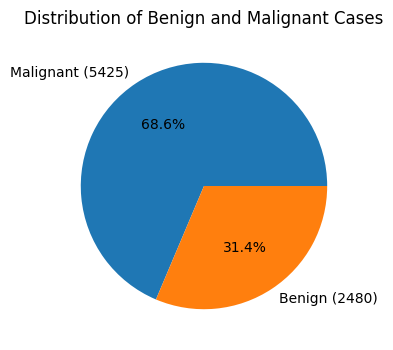

In [9]:
class_counts = img_metadata_df['Benign or Malignant'].value_counts()
class_counts.plot(kind='pie', figsize=(8, 4), autopct='%1.1f%%', labels=[f'{label} ({count})' for label, count in zip(class_counts.index, class_counts)])
plt.ylabel('')
plt.title('Distribution of Benign and Malignant Cases')
plt.show()

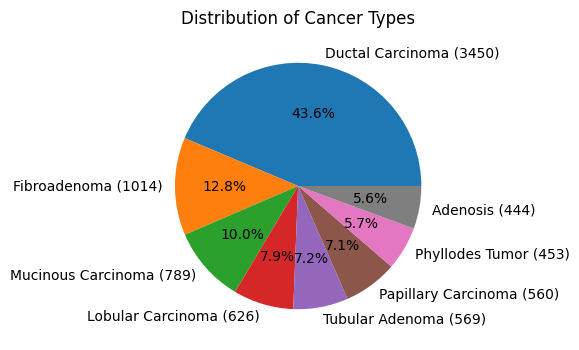

In [10]:
cancer_type_counts = img_metadata_df['Cancer Type'].value_counts()
cancer_type_counts.plot(kind='pie', figsize=(8, 4), autopct='%1.1f%%', labels=[f'{label} ({count})' for label, count in zip(cancer_type_counts.index, cancer_type_counts)])
plt.ylabel('')
plt.title('Distribution of Cancer Types')
plt.show()

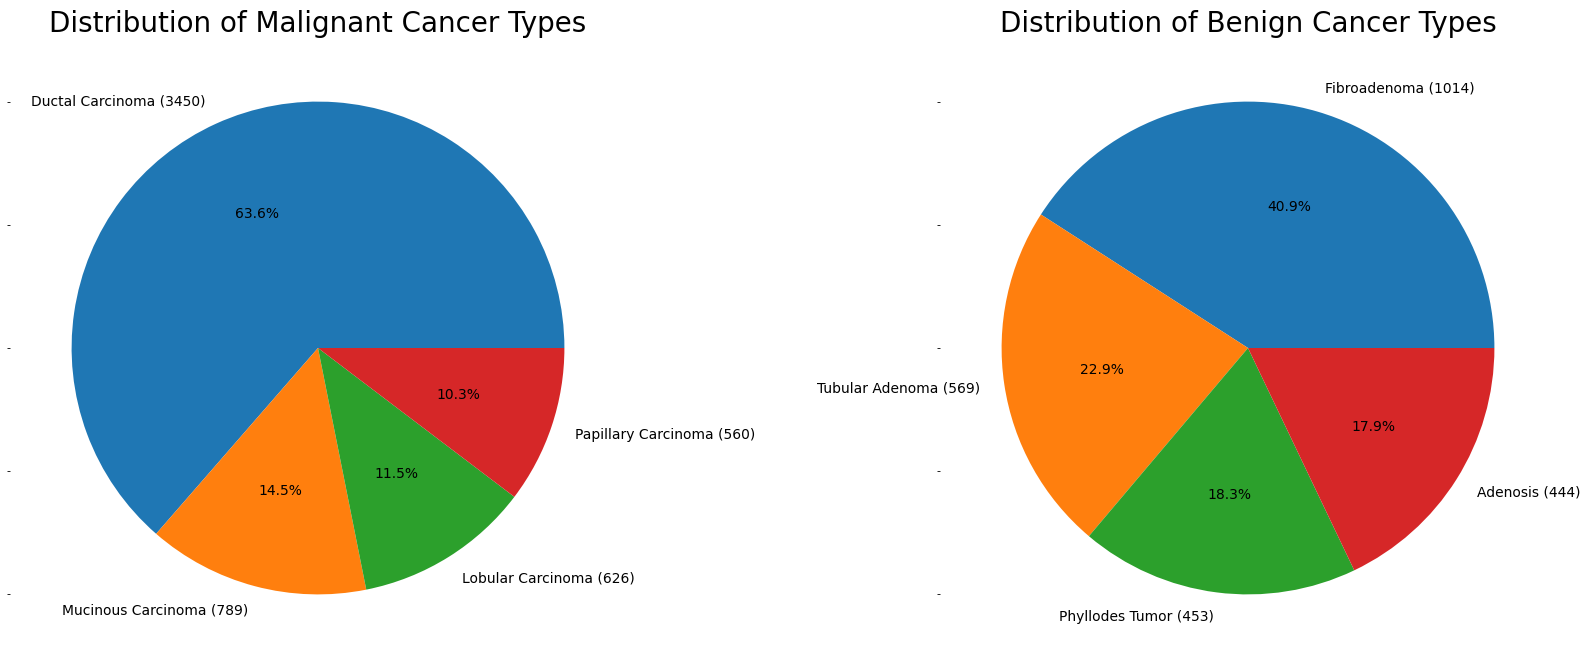

In [11]:
malignant = img_metadata_df[img_metadata_df['Benign or Malignant'] == 'Malignant']
benign = img_metadata_df[img_metadata_df['Benign or Malignant'] == 'Benign']

malignant_cancer_type_counts = malignant['Cancer Type'].value_counts()
benign_cancer_type_counts = benign['Cancer Type'].value_counts()

fig, axes = plt.subplots(figsize=(22, 8), sharey=True, ncols=2, nrows=1)

malignant_cancer_type_counts.plot(kind='pie', ax=axes[0], 
                                  autopct='%1.1f%%', 
                                  labels=[f'{label} ({count})' for label, count in zip(malignant_cancer_type_counts.index, malignant_cancer_type_counts)])
axes[0].set_ylabel('')
axes[0].set_title('Distribution of Malignant Cancer Types', fontsize=20)

benign_cancer_type_counts.plot(kind='pie', ax=axes[1], 
                               autopct='%1.1f%%', 
                               labels=[f'{label} ({count})' for label, count in zip(benign_cancer_type_counts.index, benign_cancer_type_counts)])
axes[1].set_ylabel('')
axes[1].set_title('Distribution of Benign Cancer Types', fontsize=20)

plt.show()

In [12]:
def check_image_resolutions(metadata):
    resolutions = []
    for idx, row in metadata.iterrows():
        try:
            with Image.open(row['path_to_image']) as img:
                resolutions.append(img.size)
        except Exception as e:
            print(f"Error loading image {row['path_to_image']}: {e}")
    return resolutions

resolutions = check_image_resolutions(img_metadata_df)
resolutions_df = pd.DataFrame(resolutions, columns=['width', 'height'])
print("\nImage Resolutions:\n", resolutions_df.describe())


Image Resolutions:
         width       height
count  7905.0  7905.000000
mean    700.0   459.962555
std       0.0     0.385221
min     700.0   456.000000
25%     700.0   460.000000
50%     700.0   460.000000
75%     700.0   460.000000
max     700.0   460.000000


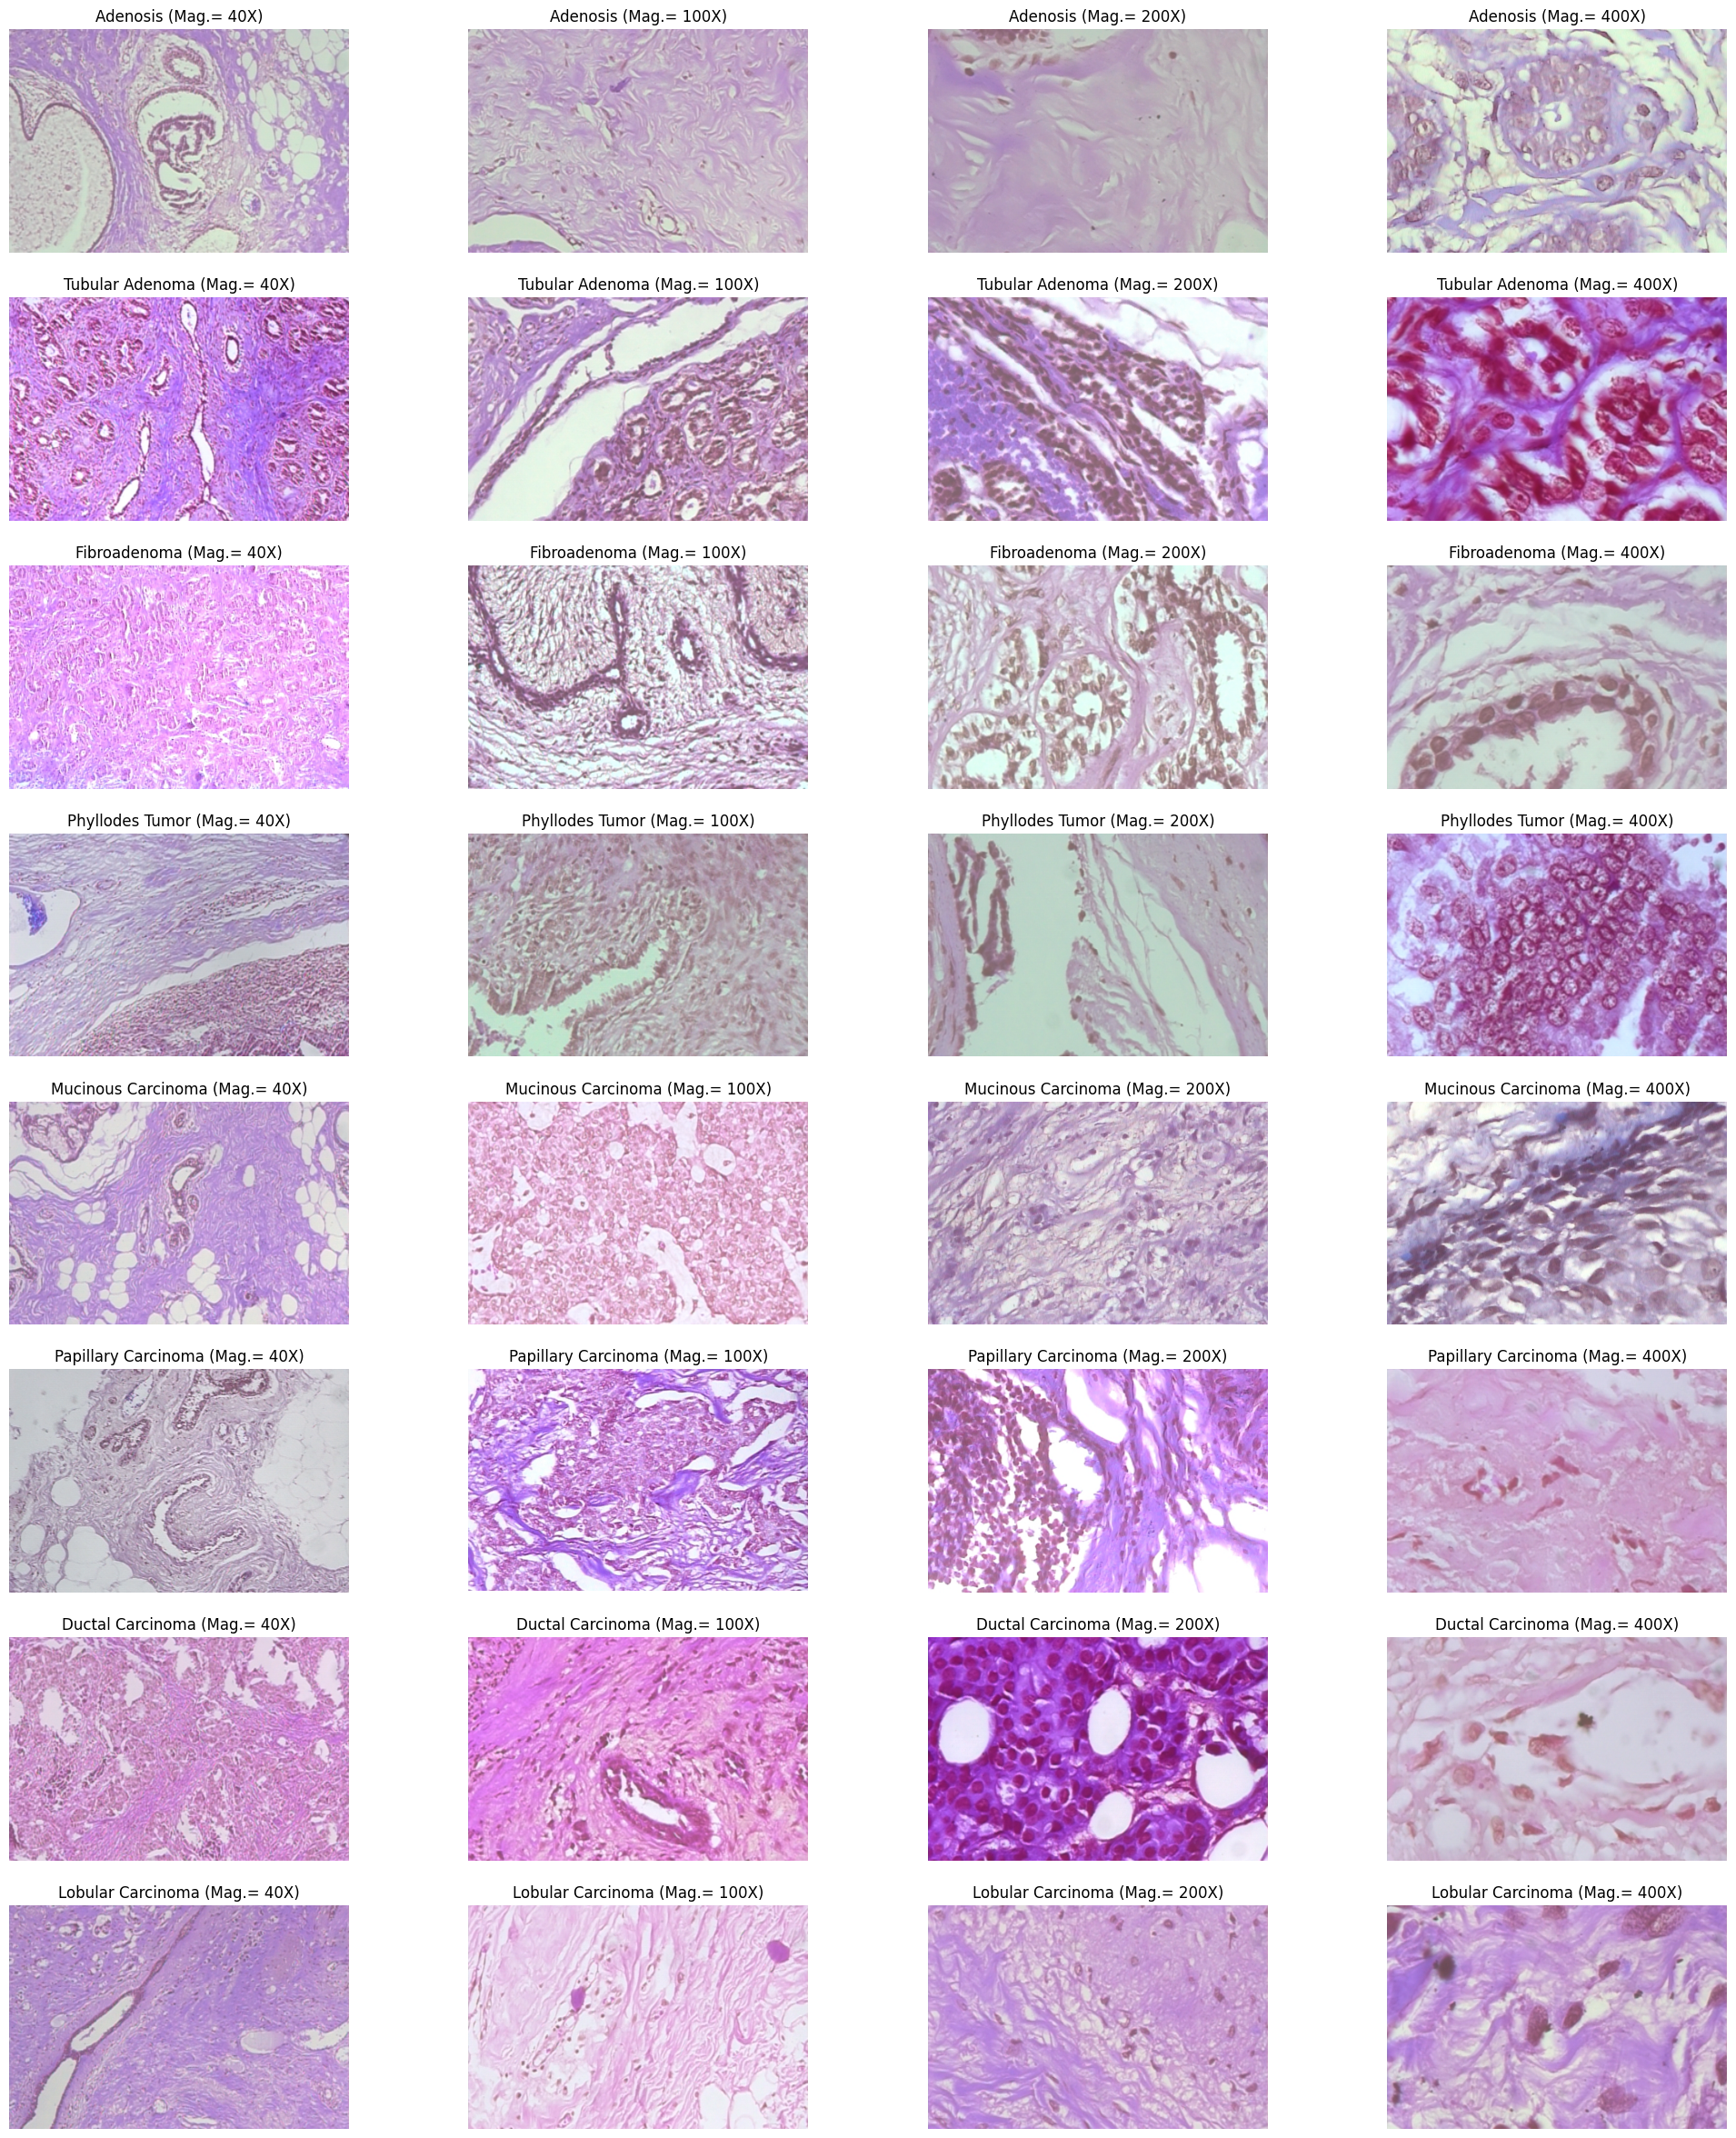

In [13]:
magnifications = ['40X', '100X', '200X', '400X']
cancer_types = list(img_metadata_df['Cancer Type'].unique())

def plot_images_compare_magnification(data, cancer_types, magnifications):
    fig, axes = plt.subplots(figsize=(25, 30), sharey=True, ncols=4, nrows=8)

    for j, cancer_type in enumerate(cancer_types):
        for i, mag in enumerate(magnifications):
            temp_df = data[(data['Cancer Type'] == cancer_type) & (data['Magnification'] == mag)]

            if temp_df.empty:
                continue

            random_id = temp_df.sample(n=1).index[0]
            image = cv2.imread(data['path_to_image'][random_id])

            axes[j][i].imshow(image)
            axes[j][i].set_title(f"{cancer_type} (Mag.= {mag})")
            axes[j][i].axis('off')
            
plot_images_compare_magnification(img_metadata_df, cancer_types, magnifications)